# <font color='blue'> fPCA applied to spatiotemporal reconstruction of EEG data around braking event   </font>

<br>

<hr>

## <font color='blue'> Description </font>

This notebook explores the construsction of a spatio temporal model using a Karhunen Loeve decomposition for the EEG data presented in 

Haufe S, Treder M S, Gugler M F, Sagebaum M, Curio G and
Blankertz B 2011 EEG potentials predict upcoming emergency
brakings during simulated driving J. Neural Eng. 8 056001

There were 18 subjects: VPae, VPbba, VPgab, VPgag, VPgam, VPja, VPbad, VPdx, VPgac, VPgah, VPih, VPsaj, VPbax, VPgaa, VPgae, VPgal, VPii, VPsal .

Their task was to drive a virtual car using the steering wheel and gas/brake pedals, and to tightly follow a computer-controlled lead vehicle. This lead vehicle occasionally decelerated abruptly. The driver was instructed to perform immediate emergency braking in these situations in order to avoid a crash.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd 

## <font color='blue'> Import data for one subject </font>

(Below same procedure for all subjects and events)

In [2]:
path_data_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/Data/'
file_name = "Raw/VPja.mat" # VPja.mat ; VPbax.mat
df_eeg_event_file = path_data_mat + 'fromJupyter/df_eeg_only_events.csv' # Corresponds to VPja

### Import 3D position of EEG electrodes
**mnt**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*Structure defining electrode positions*  <br>

In [3]:
with h5py.File(path_data_mat + file_name, 'r') as f:
    mnt = f.get('mnt')
    #print("Items in mnt", list(mnt.items()) )
    #x_pos_allChannels = np.array(mnt.get('x'))
    #y_pos_allChannels = np.array(mnt.get('y'))
    pos3d_allChannels = np.array(mnt.get('pos_3d')) # coord in 3D

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]

### Import EEG data

Import EEG data aquired from 59 scalp sites, select **nn_channels** number of electrodes or channels and time length **time_int**.

**time_int**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*Length of time interval (default 320 points, 1 point step correspond to 5ms)*  <br>
**nn_channels**  &emsp; &emsp; &emsp; &emsp; &nbsp;*Number of EEG electrodes or channels (max=59)*  <br>

In [4]:
df_eeg_events = pd.read_csv( df_eeg_event_file )

time_int = df_eeg_events.shape[1] #
nn_channels = 59

NPeeg = []
nSample = int(df_eeg_events.shape[0]/59)
for i in range(nSample):
    for k in range(nn_channels):
        NPeeg.append(np.asarray(df_eeg_events)[i * 59 + k,:time_int])
NPeeg = np.asarray(NPeeg)

### Data normalization
Remove the temporal mean of the signals to normalize them around 0.

At each time point, compute the average value of the sginal for each electorde. 

In [5]:
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # 

In [6]:
mu_t = []
x = np.arange(0, NPeegC.shape[0])
for k in range(nn_channels):
    n= x[(x % nn_channels == k) ] 
    mu_t.append(NPeegC[n,:].mean(axis=0)) 
mu_t = np.array(mu_t)

### Build spatio-temporal mesh

In [7]:
spatiotemp_mesh = []
for p in pos3d_eegChannels[:nn_channels]: #
    xi, yi, zi = tuple(p)
    for ti in range(time_int):
        spatiotemp_mesh.append([xi, yi, zi, ti])

### Transfomr EEG data in spatio-temporal mesh format 

Each entry of the object must correspond to the enties in the spatio temporal mesh

In [8]:
values = []
for k in range(nSample):
    start = k * nn_channels
    end = start + nn_channels
    values.append( (NPeegC[start:end,:] - mu_t).T) # T

##  <font color='blue'>FPCA </font>

In [9]:
# OpenTurns:
import openturns as ot
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values[k][:,j])
    field.setValues(np.array(aux).reshape(-1,1))
    process_sample[k] = field

### KarhunenLoeve </font>

In [10]:
s = 0.0 # 
w_v = np.ones(nn_channels*time_int) # verticesWeights
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) #0.0 (=s) correspond au threshold sur les valeurs propres
algo.run()

fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

### Residuals </font>

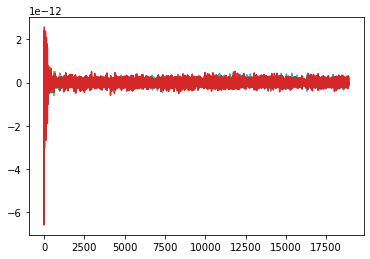

In [11]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()): 
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [12]:
mode_0_onesubject = np.asarray(fPCA.getModesAsProcessSample()[0])

### <font color='green'> Etape 2: PCA - erreur de troncature</font>

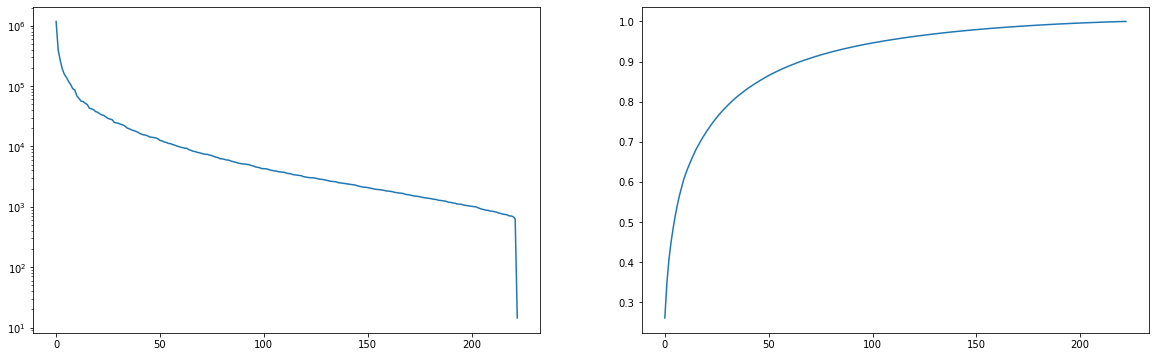

In [13]:
vp      = fPCA.getEigenValues() #  getEigenValues method enables to obtain the K first eigenvalues of the Karhunen Loeve decomposition
pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].semilogy(vp)
ax[1].plot (pVar)

## <font color='blue'> La détection d'anomalies </font>

In [14]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)

[139, 173]


### <font color='green'> Minimum Level Set </font>

On prend 2 modes (c'est plus facile pour visualiser), et on cherche la ligne de niveau qui minimise la surface sur le plan $\xi [0]$ x $\xi [1]$.

Ensuite on peut tester sur pour un signal donné, sa projection sur les 2 axes principaux est à l'intérieur ou à l'extérieur de cette surface.

 Nb Outlier =  0


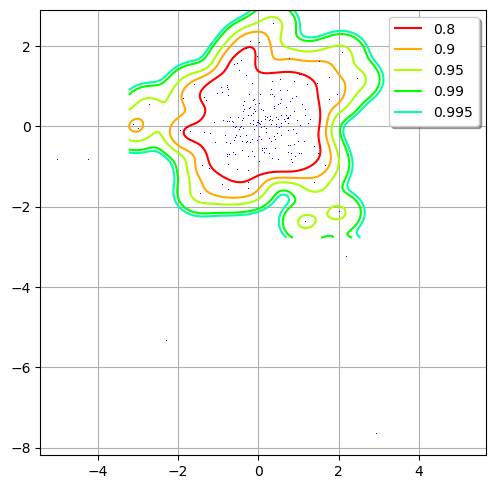

In [15]:
import openturns.viewer as otv 

#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))

## <font color='blue'> All subjects </font>

In [16]:
df_eeg_events_file = path_data_mat + 'fromJupyter/df_eeg_only_events_all_subjects.csv'# Corresponds to VPja

Import data

In [17]:
df_eeg_events = pd.read_csv( df_eeg_events_file )

time_int = df_eeg_events.shape[1] #
nn_channels = 59

NPeeg = []
nSample = int(df_eeg_events.shape[0]/59)
for i in range(nSample):
    for k in range(nn_channels):
        NPeeg.append(np.asarray(df_eeg_events)[i * 59 + k,:time_int])
NPeeg = np.asarray(NPeeg)

Normalize data

In [18]:
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # 
mu_t = []
x = np.arange(0, NPeegC.shape[0])
for k in range(nn_channels):
    n= x[(x % nn_channels == k) ] 
    mu_t.append(NPeegC[n,:].mean(axis=0)) 
mu_t = np.array(mu_t)

Format data

In [19]:
spatiotemp_mesh = []
for p in pos3d_eegChannels[:nn_channels]: #
    xi, yi, zi = tuple(p)
    for ti in range(time_int):
        spatiotemp_mesh.append([xi, yi, zi, ti])
        
values = []
for k in range(nSample):
    start = k * nn_channels
    end = start + nn_channels
    values.append( (NPeegC[start:end,:] - mu_t).T) # T

OpenTurns:

In [20]:
# OpenTurns:
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values[k][:,j])
    field.setValues(np.array(aux).reshape(-1,1))
    process_sample[k] = field

In [21]:
s = 0.0 # 
w_v = np.ones(nn_channels*time_int) # verticesWeights
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) #0.0 (=s) correspond au threshold sur les valeurs propres
algo.run()

fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

In [22]:
mode1_all = np.asarray(fPCA.getModesAsProcessSample()[0])

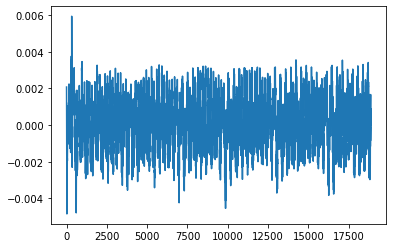

In [24]:
plt.plot(mode1_all - mode_0_onesubject) # Doesn’t seem like the same basis 

Plot some residuals (to big to plot)

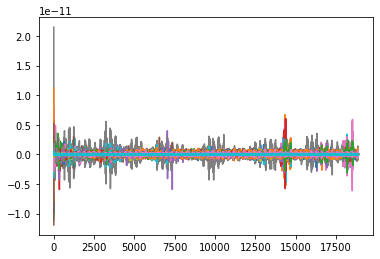

In [24]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

#for k in range(process_sample.getSize()): 
for k in range(500):  # Take only some examples to plot faster
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

Compute mean residuals and plot

In [29]:
res_mean = []
for k in range(process_sample.getSize()):  # Take only some examples to plot faster
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    res_mean.append(np.asarray(res).mean())

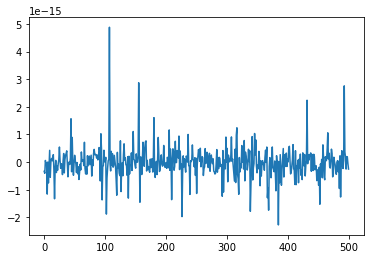

In [32]:
plt.plot(res_mean)